# Projekt zaliczeniowy z Metod Numeryczych Dla Równań Różniczkowych Zwyczajnych
## Autorzy: Maksymilian Dębowski, Konrad Baranek

In [21]:
%pip install numpy pandas matplotlib tabulate scipy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
from scipy.integrate import solve_ivp
from tabulate import tabulate

# Runge-Kutta rzędu 4 vs Adams-Bashforth rzędu 4
## Rzędy
### RK4
Porównując funkcje stabilności $$R(z) = 1 + z + \frac{z^2}{2} + \frac{z^3}{6} + \frac{z^4}{24}$$
z rozwinięciem funkcji $$e^z  = 1 + z + \frac{z^2}{2} + \frac{z^3}{6} + \frac{z^4}{24} + ...$$
widzimy pełną zgodność az do $z^4$, zatem rząd wynosi $4$.
### Adams-Bashforth
$$x_{k+4} = x_{k+3} + h (\frac{55}{24}f_{k+3} - \frac{59}{24}f_{k+2} + \frac{37}{24}f_{k+1} - \frac{9}{24}f_{k})$$
$$\alpha_{4} = 1 , \beta_{4} = 0$$
$$\alpha_{3} = -1 , \beta_{3} = \frac{55}{24}$$
$$\alpha_{2} = 0, \beta_{2} = -\frac{59}{24} $$
$$\alpha_{1} = 0, \beta_{1} = \frac{37}{24}$$
$$\alpha_{0} = 0, \beta_{0} = -\frac{9}{24}$$
Korzystajac następnie z twierdzeniu o rzędzie schematu LMM liczymy:
$$c_{0} = 1 - 1 = 0$$
$$c_{1} = 4 - 3 + \frac{55}{24} - \frac{59}{24} + \frac{37}{24} - \frac{9}{24} = 1 - 1 = 0$$
$$c_{2} = \frac{1}{2} (16 - 9) - 3 \cdot \frac{55}{24} + 2 \cdot \frac{59}{24} - \frac{37}{24} = \frac{7}{2} - \frac{7}{2} = 0 $$
$$c_{3}=c_{4} = 0 $$
(juz zbyt wiele wyliczen dla nas :)
$$c_{5} = \frac{251}{720} \neq 0$$
Zatem, rząd dokładności metody Adamsa - Bashfortha (AB4) wynosi 4.

In [23]:
def solve_rk4(f, t, y0, h):
    t_vals = np.arange(t[0], t[1] + h, h)
    num_steps = len(t_vals)
    y_vals = np.zeros((num_steps, len(y0)))
    y_vals[0, :] = y0

    for i in range(len(t_vals) - 1):
        t = t_vals[i]
        y = y_vals[i, :]

        k1 = np.asarray(f(t,y))
        k2 = np.asarray(f(t + 0.5*h, y + 0.5*h*k1))
        k3 = np.asarray(f(t + 0.5*h, y + 0.5*h*k2))
        k4 = np.asarray(f(t + h, y + h*k3))
        y_vals[i+1,:] = y + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)
    return t_vals, y_vals


def solve_ab4(fun, t, y0, h):
    t_vals = np.arange(t[0], t[1] + h, h)
    num_steps = len(t_vals)
    y_vals = np.zeros((num_steps, len(y0)))
    
    t_start, y_start = solve_rk4(fun, (t[0], t[0] + 3*h), y0, h)
    y_vals[0:4, :] = y_start[0:4, :]

    f_history = np.zeros_like(y_vals)
    for i in range(4):
        f_history[i, :] = fun(t_vals[i], y_vals[i, :])

    for i in range(3, num_steps - 1):
        f_i, f_im1, f_im2, f_im3 = f_history[i], f_history[i-1], f_history[i-2], f_history[i-3]
        
        y_next = y_vals[i, :] + (h/24) * (55*f_i - 59*f_im1 + 37*f_im2 - 9*f_im3)
        
        y_vals[i+1, :] = y_next
        f_history[i+1, :] = fun(t_vals[i+1], y_next)

    return t_vals, y_vals

In [24]:
def plot_complex_level(
    R,
    xlim=(-3, 3),
    ylim=(-3, 3),
    res=500,
    threshold=1,
    colors=("salmon", "darkseagreen"),
    alpha=0.7,
    title=None,
    figsize=(8, 6),
):
    x = np.linspace(*xlim, res)
    y = np.linspace(*ylim, res)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j * Y
    R_vectorized = np.vectorize(R, otypes=[float])
    
    R_vals = R_vectorized(Z)

    fig, ax = plt.subplots(figsize=figsize)
    
    ax.contourf(
        X, Y, R_vals, 
        levels=[0, threshold, np.max([threshold, R_vals.max()]) if R_vals.max() > threshold else threshold + 1],
        colors=colors,
        alpha=alpha
    )
    
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, color='white')

    ax.set_aspect("equal")
    ax.set_xlabel("Re(z)")
    ax.set_ylabel("Im(z)")
    if title:
        ax.set_title(title)

    legend_elems = [
        Patch(facecolor=colors[0], alpha=alpha, label=f"Stabilna (|p(z)| < {threshold})"),
        Patch(facecolor=colors[1], alpha=alpha, label=f"Niestabilna (|p(z)| ≥ {threshold})"),
    ]
    ax.legend(handles=legend_elems, loc="upper right")

    plt.tight_layout()
    plt.show()
    return fig, ax


In [25]:
def rk4_stability(z):
    return np.abs(1 + z + z**2/2 + z**3/6 + z**4/24)

def ab4_stability(z):
    if z == 0:
        return 1.0
    coeffs = [1, -(1 + 55/24 * z), (59/24 * z), -(37/24 * z), (9/24 * z)]
    roots = np.roots(coeffs)
    return np.max(np.abs(roots))

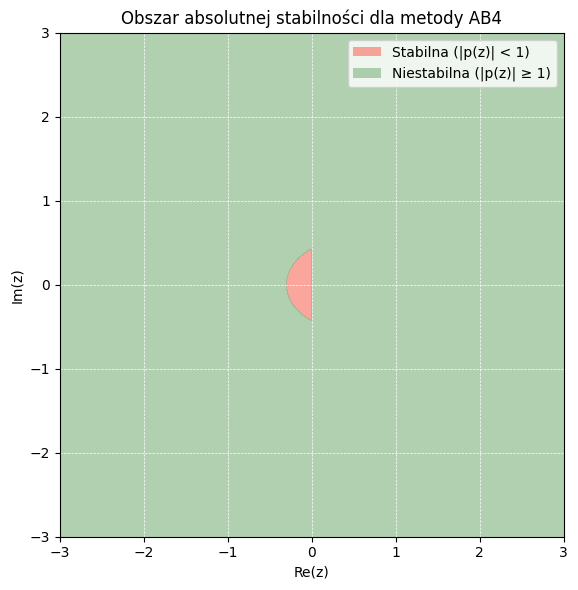

In [26]:
plot_complex_level(ab4_stability,title="Obszar absolutnej stabilności dla metody AB4")
plt.show()  

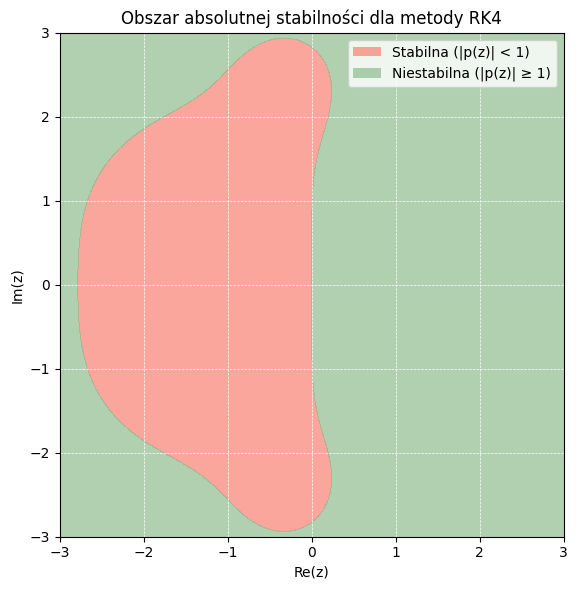

In [27]:
plot_complex_level(rk4_stability, title="Obszar absolutnej stabilności dla metody RK4")
plt.show()

## A - stabilność
Metoda numeryczna jest A-stabilna, jeśli jej obszar stabilności pokrywa całą lewą półplaszczyznę zespoloną, tj. zbiór $$\{ z \in \mathbf{C}: Re(z) \leq 0\}$$
Dla RK4 wystarczy wziąć punkt $z = -3$, by zobaczyć ze w tym przypadku nie jest spełniony ten warunek.

Analogicznie w przypadku Adamsa-Bashfortha 4, w którym wyznaczyliśmy obszar absolutnej stabilności jako zbiór tych $z$, dla których pierwiastki wielomianu charakterystycznego 
$$\rho(\xi, z) = \xi^4 - \xi^3 - \frac{z}{24}(55\xi^3 - 59\xi^2 + 37\xi -9) = 0$$
są $\leq 1$

Równiez pierwszy rzut oka na rysunek wystarczy, by stwierdzić, ze metoda AB4 nie jest A - stabilna.

In [28]:
a = 1.1 # Współczynnik przyrostu ofiar
b = 0.5 # Częstość umierania ofiar na skutek drapieżnictwa
c = 0.1 # Współczynnik przyrostu drapieznikow
d = 0.4 # Czestość umierania drapieznikow
t_lim = (0, 100)
y0 = [20, 5] # 20 ofiar, 5 drapieznikow jako warunek poczatkowy
h = 0.05 # krok

Model Lotki-Volterry, znany również jako model drapieżnik-ofiara, opisuje dynamikę populacji dwóch gatunków: ofiar oraz drapieżników. Jest to układ dwóch nieliniowych równań różniczkowych zwyczajnych:

$$
\begin{cases}
\frac{dx}{dt} = a x - b x y \\
\frac{dy}{dt} = c x y - d y
\end{cases}
$$

gdzie:
- $x$ – liczebność populacji ofiar,
- $y$ – liczebność populacji drapieżników,
- $a$ – współczynnik przyrostu naturalnego ofiar,
- $b$ – współczynnik śmiertelności ofiar na skutek drapieżnictwa,
- $c$ – współczynnik przyrostu drapieżników dzięki polowaniu,
- $d$ – współczynnik śmiertelności drapieżników.

Założenia modelu:
- Ofiary rozmnażają się wykładniczo w przypadku braku drapieżników.
- Drapieżniki wymierają w przypadku braku ofiar.
- Interakcje pomiędzy gatunkami są proporcjonalne do iloczynu ich liczebności.

Model ten pozwala analizować cykliczne zmiany liczebności obu populacji oraz ich wzajemne zależności w czasie.

In [29]:
def lotka_volterra(t, y):
    x, y_pred = y
    dxdt = (a - b * y_pred) * x
    dydt = (c * x -d ) * y_pred
    return [dxdt, dydt]

In [30]:
t_rk4, y_rk4 = solve_rk4(lotka_volterra, t_lim, y0, h)
t_ab4, y_ab4 = solve_ab4(lotka_volterra, t_lim, y0, h)
# Dense_output = True, zeby dostac rozwiazanie w kazdym punkcie (porownac potem rzetelnie z wynikami rk4, ab4)
sol_exact = solve_ivp(lotka_volterra, t_lim, y0, dense_output = True, rtol = 1e-12, atol = 1e-12)
y_exact = sol_exact.sol(t_rk4)

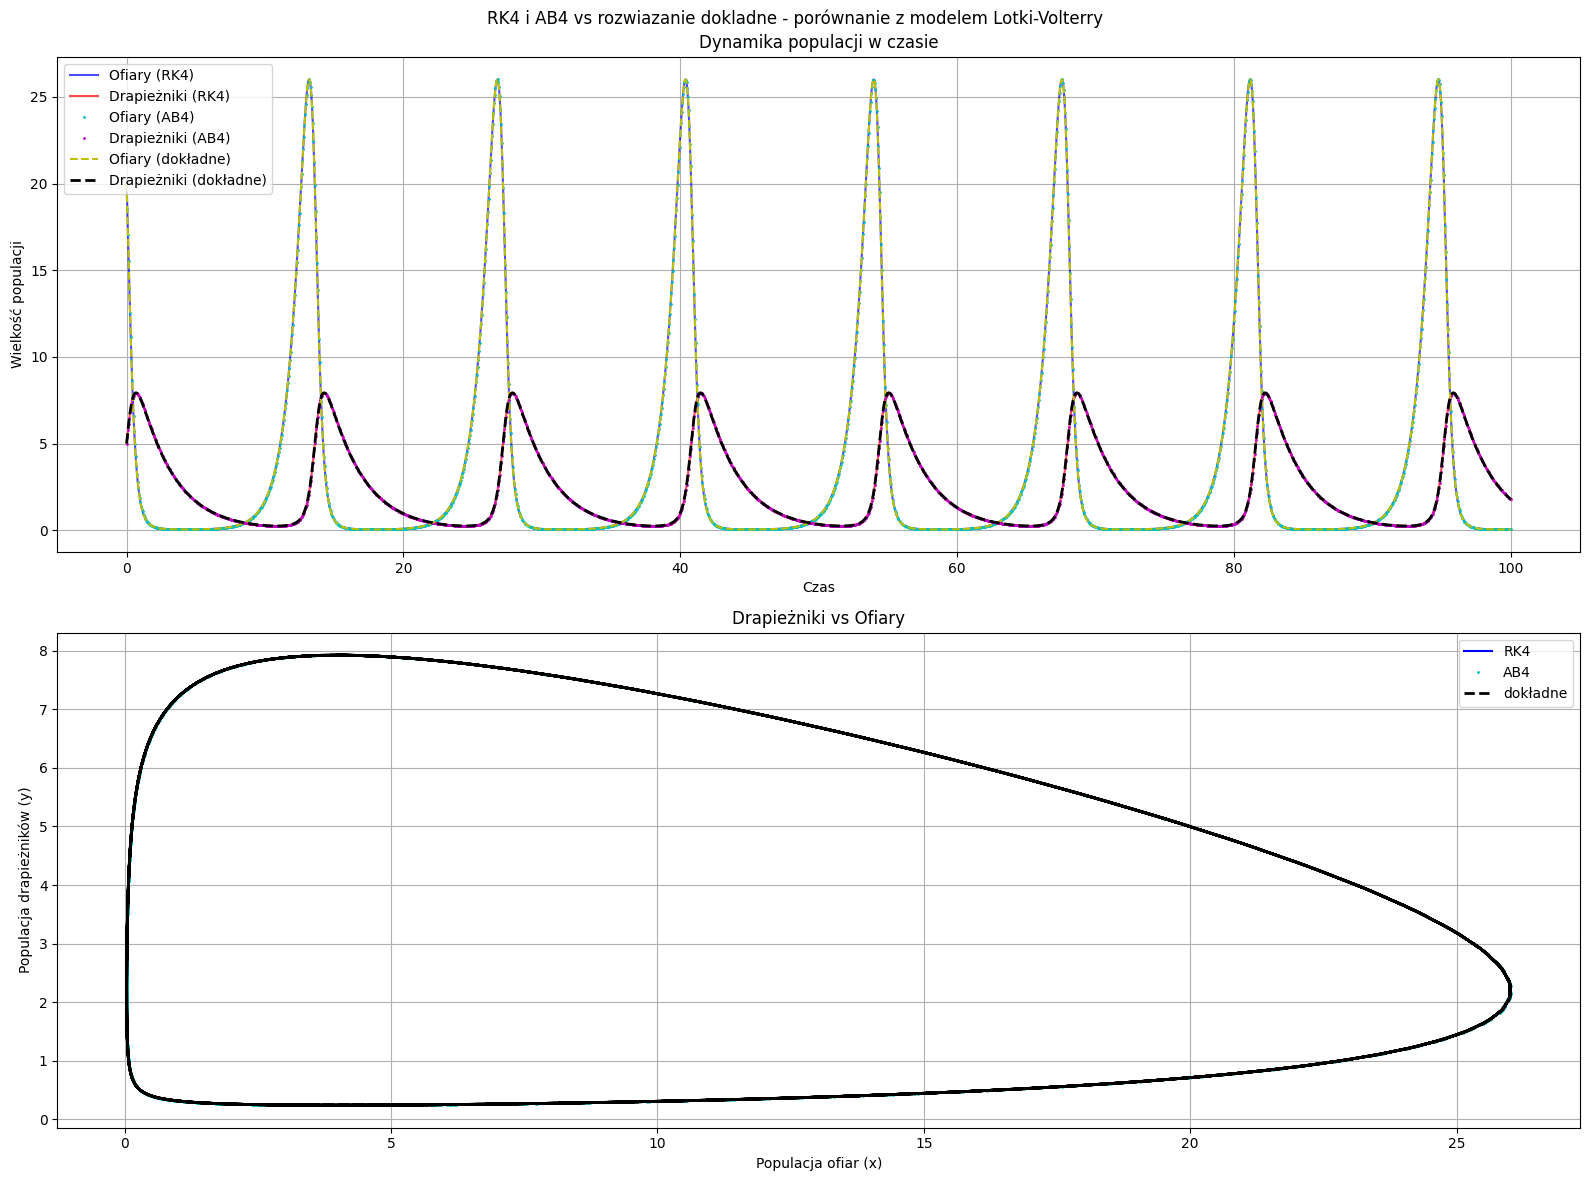

In [31]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
fig.suptitle("RK4 i AB4 vs rozwiazanie dokladne - porównanie z modelem Lotki-Volterry")

ax[0].plot(t_rk4, y_rk4[:, 0], 'b-', label='Ofiary (RK4)', alpha=0.7)
ax[0].plot(t_rk4, y_rk4[:, 1], 'r-', label='Drapieżniki (RK4)', alpha=0.7)
ax[0].plot(t_ab4, y_ab4[:, 0], 'c.', markersize=2, label='Ofiary (AB4)')
ax[0].plot(t_ab4, y_ab4[:, 1], 'm.', markersize=2, label='Drapieżniki (AB4)')
ax[0].plot(t_rk4, y_exact[0, :], 'y--', label='Ofiary (dokładne)')
ax[0].plot(t_rk4, y_exact[1, :], 'k--', label='Drapieżniki (dokładne)', lw=2)
ax[0].set_title("Dynamika populacji w czasie")
ax[0].set_xlabel("Czas")
ax[0].set_ylabel("Wielkość populacji")
ax[0].legend()
ax[0].grid(True)

ax[1].plot(y_rk4[:, 0], y_rk4[:, 1], 'b-', label='RK4')
ax[1].plot(y_ab4[:, 0], y_ab4[:, 1], 'c.', markersize=2, label='AB4')
ax[1].plot(y_exact[0, :], y_exact[1, :], 'k--', label='dokładne', lw=2)
ax[1].set_title("Drapieżniki vs Ofiary")
ax[1].set_xlabel("Populacja ofiar (x)")
ax[1].set_ylabel("Populacja drapieżników (y)")
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show()


In [32]:
def analiza_rzedu(solver):
    T_0 = 0.0
    T_final = 100.0
    t_lim = (T_0, T_final)
    Y_0 = np.array([20.0, 5.0]) # 20 ofiar, 5 drapieznikow

    ref = solve_ivp(lotka_volterra, t_lim, Y_0, rtol = 1e-12, atol = 1e-12)
    y_ref_final = ref.y[:, -1]

    res = {"N" : [], "h": [], "||Y_N - Y_ref||": []}

    N = 200

    for _ in range(8):
        N *= 2
        h = (T_final -  T_0) / N
        t_vals, y_vals = solver(lotka_volterra, t_lim, Y_0, h)
        y_numerical_final = y_vals[-1]
        error_norm = np.linalg.norm(y_numerical_final - y_ref_final)
        res["N"].append(N)
        res["h"].append(h)
        res["||Y_N - Y_ref||"].append(error_norm)
    
    res_df = pd.DataFrame(res)
    
    res_df['err_n/err_2n'] = res_df['||Y_N - Y_ref||'].shift(1) / res_df['||Y_N - Y_ref||']
    res_df['p'] = np.log2(res_df['err_n/err_2n'])

    print(tabulate(res_df, headers='keys', tablefmt='grid', 
               numalign='center', stralign='center', showindex=False))
    plt.figure(figsize=(10, 8))
    
    plt.loglog(res_df["h"], res_df["||Y_N - Y_ref||"], 
               marker='o', linestyle = 'none')
    
    h_vals = res_df['h']
    C = res_df['||Y_N - Y_ref||'].iloc[-1] / (h_vals.iloc[-1]**4)
    plt.loglog(h_vals, C * h_vals**4, 'k--', label='Prosta referencyjna $O(h^4)$')

    plt.title(f'Wykres log-log')
    plt.xlabel('Krok czasowy h')
    plt.ylabel('Błąd E(h)')
    plt.grid(True) 
    plt.legend() 
    plt.show()

+-------+------------+-------------------+----------------+---------+
|   N   |     h      |  ||Y_N - Y_ref||  |  err_n/err_2n  |    p    |
+=======+============+===================+================+=========+
|  400  |    0.25    |     0.135186      |      nan       |   nan   |
+-------+------------+-------------------+----------------+---------+
|  800  |   0.125    |    0.00623445     |    21.6837     | 4.43854 |
+-------+------------+-------------------+----------------+---------+
| 1600  |   0.0625   |    0.000318598    |    19.5684     | 4.29045 |
+-------+------------+-------------------+----------------+---------+
| 3200  |  0.03125   |    1.78077e-05    |     17.891     | 4.16116 |
+-------+------------+-------------------+----------------+---------+
| 6400  |  0.015625  |     1.049e-06     |    16.9759     | 4.08542 |
+-------+------------+-------------------+----------------+---------+
| 12800 | 0.0078125  |    6.34814e-08    |    16.5245     | 4.04654 |
+-------+-----------

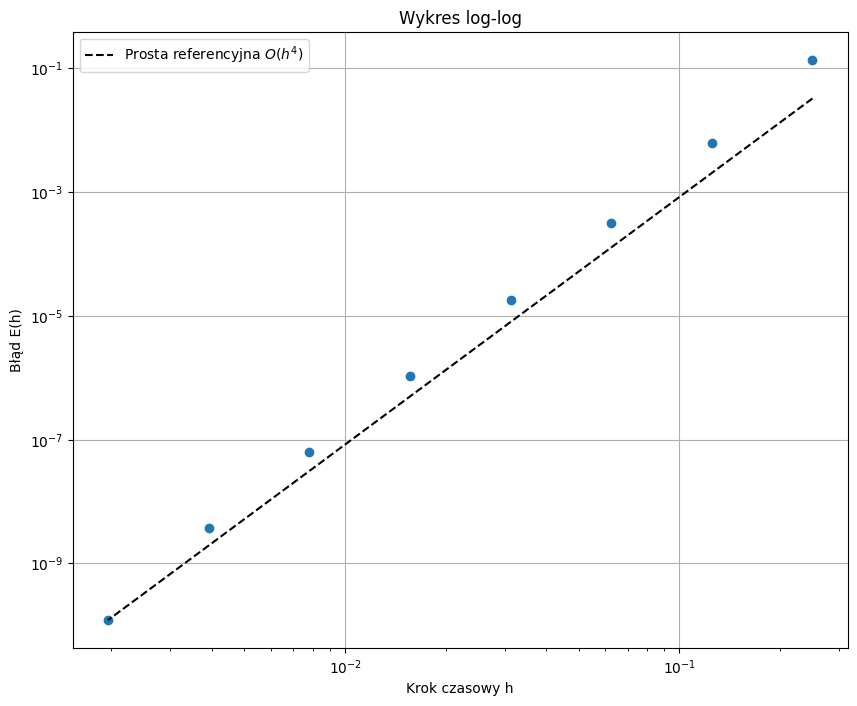

In [33]:
analiza_rzedu(solve_rk4)

+-------+------------+-------------------+----------------+---------+
|   N   |     h      |  ||Y_N - Y_ref||  |  err_n/err_2n  |    p    |
+=======+============+===================+================+=========+
|  400  |    0.25    |      0.70454      |      nan       |   nan   |
+-------+------------+-------------------+----------------+---------+
|  800  |   0.125    |     0.132929      |    5.30011     | 2.40602 |
+-------+------------+-------------------+----------------+---------+
| 1600  |   0.0625   |    0.00980937     |    13.5512     | 3.76035 |
+-------+------------+-------------------+----------------+---------+
| 3200  |  0.03125   |    0.000619364    |    15.8378     | 3.9853  |
+-------+------------+-------------------+----------------+---------+
| 6400  |  0.015625  |    3.83971e-05    |    16.1305     | 4.01172 |
+-------+------------+-------------------+----------------+---------+
| 12800 | 0.0078125  |    2.38379e-06    |    16.1076     | 4.00967 |
+-------+-----------

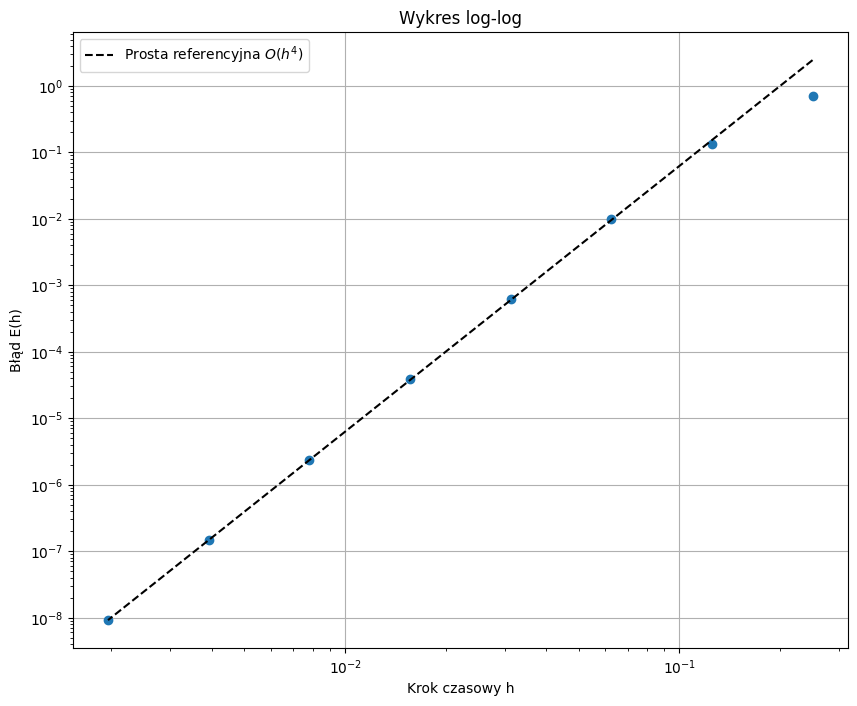

In [34]:
analiza_rzedu(solve_ab4)

Przykład z przykładowego kolokwium 

$$\left\{\begin{array}{rcl}
x_{1}'&=&-3x_{1}+2x_{2}\\
x_{2}'&=&-x_{1}\\
\end{array} \right.$$

$$A = \left[\begin{array}{ccc}
-3&2\\
-1&0
\end{array}\right]$$
Liczymy wartości własne
$$\lambda_{1} = -1, \lambda_{2} = -2$$

RK4:
- stabilny -> h = $1.0$, bo $1.0 * -2 = -2.0$ i $1.0 * -1 = -1$, widać na przygotowanym wyzej wykresie, ze oba leza w obszarze absolutnej stabilnosci.
- krytyczny -> h = $1.5$, bo $1.5 * -2 = -3.0$ i widac, ze lezy poza obszarem absolutnej stabilnosci.
- graniczny -> tu gorzej, bo trzeba rozwiązywać równanie i szukac pierwiastkow ujemnych. Interesuje nas oś rzeczywista, bo wartosci wlasne sa rzeczywiste. 
$$|1+x+\frac{x^2}{2} + \frac{x^3}{6} + \frac{x^4}{4}| = 1$$
rozbijamy to na dwa równania
$$
\begin{align}
1+x+\frac{x^2}{2} + \frac{x^3}{6} + \frac{x^4}{24} &= 1 \\
1+x+\frac{x^2}{2} + \frac{x^3}{6} + \frac{x^4}{24} &= -1
\end{align}
$$
a dalej pomoze nam numpy.

In [35]:
# przypadek (1): 1/24 x^4 + 1/6 x^3 + 1/2 x^2 + x = 0
coeffs_uno = [1/24, 1/6, 1/2, 1, 0]

# przypadek (2): 1/24 x^4 + 1/6 x^3 + 1/2 x^2 + x + 2 = 0
coeffs_secundo = [1/24, 1/6, 1/2, 1, 2]

pierw_uno = np.roots(coeffs_uno)
pierw_secundo = np.roots(coeffs_secundo)

real_pierw_uno = pierw_uno[np.isreal(pierw_uno)].real
real_pierw_secundo = pierw_secundo[np.isreal(pierw_secundo)].real

print(f"(R(x)=1):{np.sort(real_pierw_uno)}")
print(f"(R(x)=-1):{np.sort(real_pierw_secundo)}")

(R(x)=1):[-2.78529356  0.        ]
(R(x)=-1):[]


Zdefiniujmy h graniczne, h krytyczne i h stabilne dla RK4.

In [36]:
h_graniczne_rk4 = float(real_pierw_uno[0])/-2.0
h_stabilne_rk4 = 1.0
h_krytyczne_rk4 = 1.5

Analiza stabilności metody RK4 dla układu liniowego

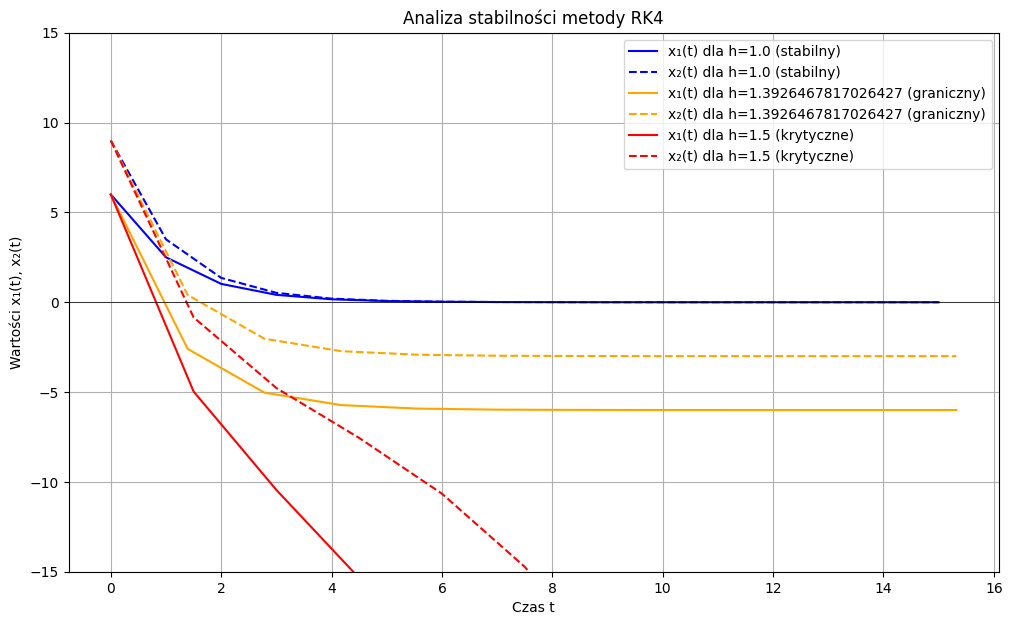

In [37]:
A = np.array([
    [-3, 2],
    [-1, 0]
])

def lin_system(t,y):
    return np.matmul(A,y)


y0 = [6.0, 9.0] # x1(0) = 6.0, x2(0) = 9.0
t_lim = (0, 15)
colors = ['blue', 'orange', 'red'] 
plt.figure(figsize=(12, 7))
plt.title("Analiza stabilności metody RK4")
h_cases_rk4 = [(h_stabilne_rk4, "stabilny"), (h_graniczne_rk4, "graniczny"), (h_krytyczne_rk4, "krytyczne")]

for i, (h, status) in enumerate(h_cases_rk4):
    t_vals, y_vals = solve_rk4(lin_system, t_lim, y0, h)
    
    plt.plot(t_vals, y_vals[:, 0], color=colors[i], linestyle='-', label=f'x₁(t) dla h={h} ({status})')
    plt.plot(t_vals, y_vals[:, 1], color=colors[i], linestyle='--', label=f'x₂(t) dla h={h} ({status})')

plt.xlabel("Czas t")
plt.ylabel("Wartości x₁(t), x₂(t)")
plt.legend()
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5) 
plt.ylim(-15,15)
plt.show()



## AB4
By znaleźć granice obszaru absolutnej stabilności na ujemnej osi rzeczywistej musimy sprawdzić dla jakiej wartości $$z = x, \ ( x\in \mathbb{R})$$
jeden z pierwiastków wielomianu charakterystycznego jest równy -1. Zatem wstawiajac tutaj $\xi = 1$ i $\xi = -1$ otrzymamy granice na osi liczb rzeczywistych.
$$\rho(\xi, z) = \xi^4 - \xi^3 - \frac{z}{24}(55\xi^3 - 59\xi^2 + 37\xi -9) = 0$$
Dla $\xi = 1$ otrzymujemy 
$$1 - 1 - \frac{z}{24}(55-59+37 - 9) = 0$$
$$ - z = 0$$
więc jedną wartoscia graniczną jest 0, drugą:
$$1 + 1 - \frac{z}{24}(-55-59-37-9) = 0$$
$$-\frac{-160z}{24} = -2$$
$$z = -\frac{3}{10}$$

Zatem $h_{graniczne} * (-2) = -0.3 \rightarrow h_{graniczne} = 0.15$

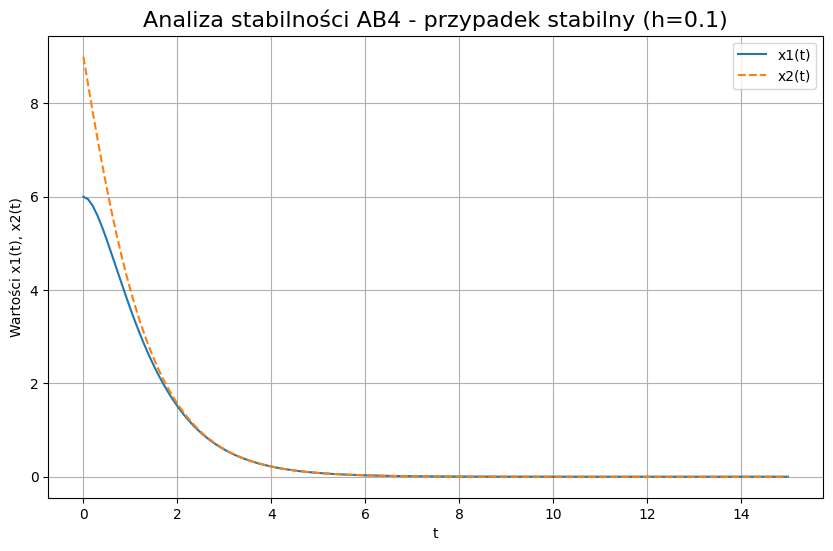

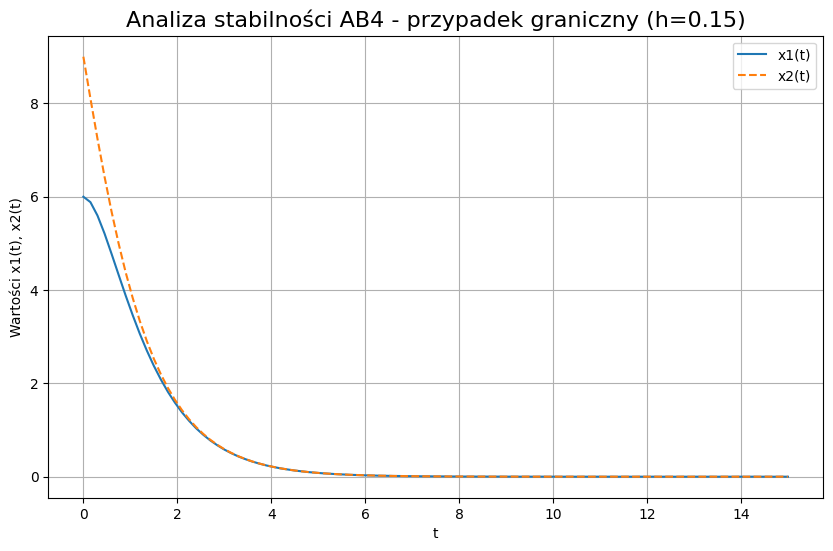

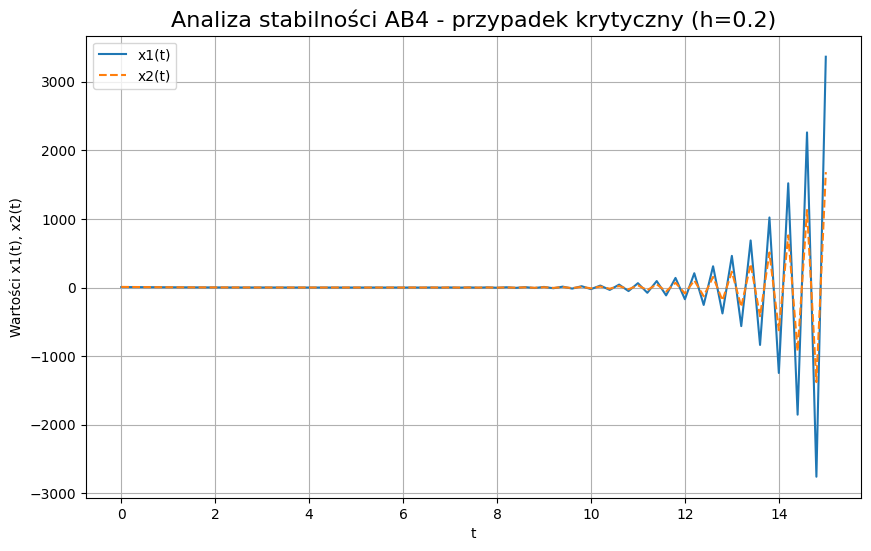

In [38]:
h_stabilne_ab4 = 0.1
h_graniczne_ab4 = 0.15
h_krytyczne_ab4 = 0.2
h_cases_ab4 = [(h_stabilne_ab4, "stabilny"), (h_graniczne_ab4, "graniczny"), (h_krytyczne_ab4, "krytyczny")]

for h, status in h_cases_ab4:
    t_vals, y_vals = solve_ab4(lin_system, t_lim, y0, h)
    
    if t_vals is not None:
        plt.figure(figsize=(10, 6))
        plt.title(f'Analiza stabilności AB4 - przypadek {status} (h={h})', fontsize=16)
        
        plt.plot(t_vals, y_vals[:, 0], linestyle='-', label=f'x1(t)')
        plt.plot(t_vals, y_vals[:, 1], linestyle='--', label=f'x2(t)')
        
        plt.xlabel("t")
        plt.ylabel("Wartości x1(t), x2(t)")
        plt.legend()
        plt.grid(True)
        plt.show()
